### RSSI to Grayscale

In [1]:
## import libraries

import os
import numpy as np
import pandas as pd
from PIL import Image
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
## read dataset
df = pd.read_csv('dataset_rssi.csv')
df2= pd.read_csv('datatest_rssi.csv')

In [3]:
## do normalization

def normalize(x):
    return (0.0) + (x - (-100)) * (255.0 - 0.0) / (0.0 - (-100))

df_ = df.iloc[:,:8].assign(n=0).apply(normalize,axis=1).values.reshape(1489,3,3)
df2_= df2.iloc[:,:8].assign(n=0).apply(normalize,axis=1).values.reshape(455,3,3)
# df3_= df.iloc[:,-1:].assign(n=0).apply(normalize,axis=1).values.reshape(1489,1)

In [4]:
x_train = df_.astype('float32')
x_test = df2_.astype('float32')
# y_test = df3_.astype('float32')
x_train = x_train/255.0
x_test = x_test/255.0
y_test = df2.iloc[:,-1:]
y_test2 = df2.iloc[: , -1]

In [5]:
y_test = np.array(y_test, dtype=np.int8)
y_test = y_test.view(np.uint8)
y_test += 0
# print (y_test)

In [6]:
y_test2 = np.array(y_test, dtype=np.int8)
y_test2 = y_test2.view(np.uint8)
y_test2 += 0
# print (y_test)

In [7]:
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
# y_test = 
input_shape = (img_height, img_width, num_channels)

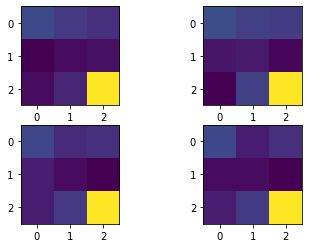

In [23]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[0][:,:,0])

plt.subplot(222)
plt.imshow(x_train[1][:,:,0])

plt.subplot(223)
plt.imshow(x_train[2][:,:,0])

plt.subplot(224)
plt.imshow(x_train[3][:,:,0])
plt.show()

In [9]:
x_train[0]

array([[[0.48000002],
        [0.44      ],
        [0.42      ]],

       [[0.33      ],
        [0.35      ],
        [0.36      ]],

       [[0.35      ],
        [0.4       ],
        [1.        ]]], dtype=float32)

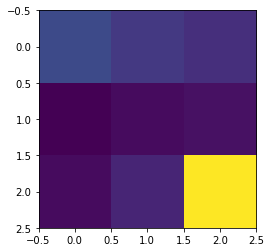

In [10]:
plt.imshow(x_train[0][:,:,0])

In [11]:
latent_dim = 2 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(16, 3, padding='same', activation='relu')(input_img)
x = Conv2D(32, 3, padding='same', activation='relu',strides=(3, 3))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

2022-03-16 09:51:36.543662: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 09:51:36.544066: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 16)     160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 1, 32)     4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1, 1, 64)     18496       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [13]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(3, 3))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)


# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 3, 3, 32)          18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 3, 3, 1)           289       
Total params: 18,945
Trainable params: 18,945
Non-trainable params: 0
_________________________________________________________________


In [14]:
# =================
# VAE 
# =================
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

# Train autoencoder
vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)


/Users/macbookprom1/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 16)     160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 1, 32)     4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1, 1, 64)     18496       conv2d_2[0][0]                   
________________________________________________________________________________________________

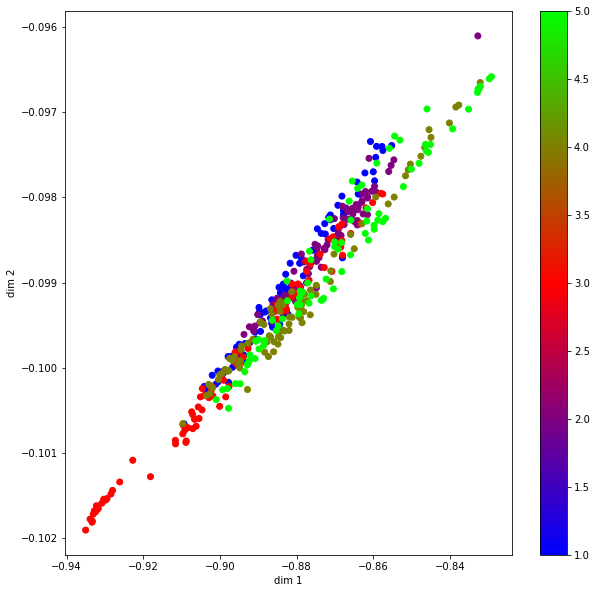

In [15]:
mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

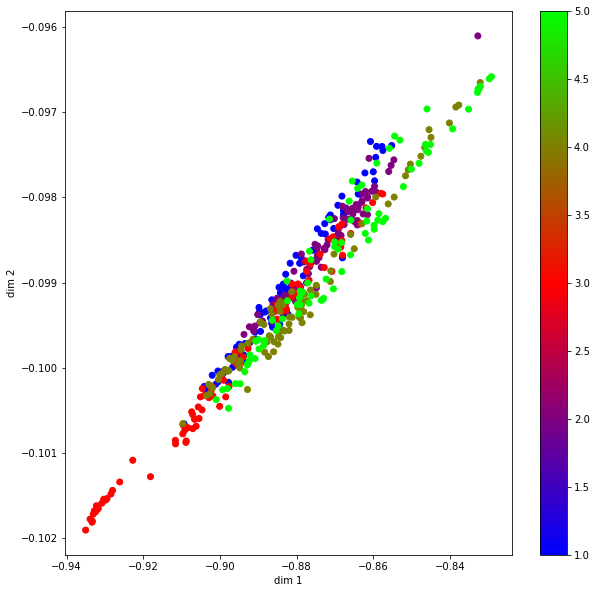

In [16]:
mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test2, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

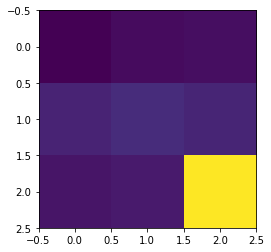

In [17]:
# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[1.6, 0]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


In [18]:
decoded_example_reshaped

array([[0.313635  , 0.3346285 , 0.34023964],
       [0.38169843, 0.39924452, 0.38520592],
       [0.35195532, 0.3636585 , 0.99685764]], dtype=float32)

In [19]:
## for one row

# img = Image.fromarray(df_[0]).resize((28,28), Image.ANTIALIAS).convert("L")
# img.show()
# img.convert("L").save('1.jpg')

In [20]:
## for the whole rows, group by coordinate

# def cvt_rssi_to_img(df, coord):
#     x_, y_ = coord[0], coord[1]
#     os.makedirs(f"image/{int(x_)}{int(y_)}", exist_ok = True)
    
#     df_ = df.assign(n=0.0).loc[lambda x: (x['8'] == x_) & (x['9'] == y_)]\
#                         [['0','1','2','3','4','5','6','7','n']]\
#                         .apply(normalize,axis=1)
#     rows, count = df_.shape[0], 1
    
#     for arr in df_.values.reshape(rows,3,3):
#         img = Image.fromarray(arr).resize((28,28), Image.ANTIALIAS).convert("L")
#         img.save(f"image/{int(x_)}{int(y_)}/{count}.jpg")
#         count += 1

In [21]:
# coords = [
#     (1.0, 1.0),
#     (1.0, 2.0),
#     (3.0, 4.0),
#     (5.0, 5.0)
# ]

# for coord in coords:
#     cvt_rssi_to_img(df, coord)

##### Appendix

In [22]:
# #  Normalization formula (pls evaluate later)
# def normalize(values, bounds):
#     return [bounds['desired']['lower'] + 
#             (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / 
#             (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

# normalize(
#     df.iloc[0,0:8].to_list(),
#     {'actual': {'lower': -100, 'upper': 0}, 'desired': {'lower': 0.0, 'upper': 255.0}}
# )